<a href="https://colab.research.google.com/github/chuducthang77/Machine-Learning-tutorials-and-notes/blob/main/4_DA%2CFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import time
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Customize preprocessing

In [ ]:
# Define a custom normalize
class Custom_normalize:
  def __init__(self, mean, std):
    self.std = std
    self.mean = mean

  def __call__(self, x):
    return  (x - mean) * 2 / (std - mean) - 1

mean = 0
std = 1

In [ ]:
# Define dataset
dataset_name = 'FashionMNIST'
batch_size = 256

augmentations = [transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip()]
train_transform = transforms.Compose([
    transforms.ToTensor(),
    Custom_normalize(mean, std)
] + augmentations)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    Custom_normalize(mean, std)
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=test_transform, download=True)

# Reduce the training to show the purpose of finetuning
maps = {i: [] for i in range(10)}
for idx, (_, cls_idx) in enumerate(train_dataset):
    if len(maps[cls_idx]) < 500:
        maps[cls_idx].append(idx)

indices = []
for _, ind in maps.items():
    indices += ind

train_dataset = torch.utils.data.Subset(train_dataset, indices)

# Create dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 120742046.48it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5826464.09it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65057981.25it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21463496.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Part 2: Finetuning

In [ ]:
# Define model
class MiniVGG(nn.Module):
    def __init__(
        self,
        ):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256 * 3 * 3, 10)
        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(
        self,
        x,
        ):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Define training loop
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch,
    device
    ):

    model.train()
    running_corrects = 0
    epoch_loss_train = 0.0

    # Iterate over data.
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item() * inputs.size(0)

    epoch_loss_train /= len(train_loader.dataset)

    print("Epoch: {} Train loss: {:.4f}".format(epoch + 1, epoch_loss_train))

    return model


In [ ]:
# Define testing loop
def test(
    model,
    test_loader,
    criterion,
    device):

    size = len(test_loader.dataset)
    corrects = 0

    model.eval()
    with torch.no_grad():
        for inputs, gts in test_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            # Forward only
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            corrects += torch.sum(preds == gts.data)

            gts = gts.to(device)

    acc = corrects / size
    print("Test Acc: {:.4f}".format(acc))

    return acc

In [ ]:
# Define hyperparameter
lr = 1e-3
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train on Cifar-10 pretrained model
model = MiniVGG()

# Load Cifar-10 pretrained model
model.load_state_dict(torch.load('/content/drive/MyDrive/NEU/cifar10_mini_vgg.pth'))
nn.init.normal_(model.classifier.weight, 0, 0.01)
nn.init.constant_(model.classifier.bias, 0)
for param in model.features.parameters():
  param.require_grad = False

# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Put the model to cuda if available
model = model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(epochs):
  # Train model
  model = train(model, criterion, optimizer, train_loader, epoch, device)

  # Test model
  epoch_acc = test(model, test_loader, criterion, device)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    best_model_wts = copy.deepcopy(model.state_dict())
    # print("Test Acc: {:.4f}".format(epoch_acc))

print()
print("Best Acc: {:.4f}".format(best_acc))


Epoch: 1 Train loss: 0.8528
Test Acc: 0.8043
Epoch: 2 Train loss: 0.4110
Test Acc: 0.8570
Epoch: 3 Train loss: 0.3276
Test Acc: 0.8625

Best Acc: 0.8625


In [ ]:
# Train on MNIST pretrained model
model = MiniVGG()

# Load MNIST pretrained model
model.load_state_dict(torch.load('/content/drive/MyDrive/NEU/mnist_mini_vgg.pth'))
nn.init.normal_(model.classifier.weight, 0, 0.01)
nn.init.constant_(model.classifier.bias, 0)
for param in model.features.parameters():
  param.require_grad = False

# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Put the model to cuda if available
model = model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(epochs):
  # Train model
  model = train(model, criterion, optimizer, train_loader, epoch, device)

  # Test model
  epoch_acc = test(model, test_loader, criterion, device)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    best_model_wts = copy.deepcopy(model.state_dict())

print()
print("Best Acc: {:.4f}".format(best_acc))

Epoch: 1 Train loss: 1.0630
Test Acc: 0.7627
Epoch: 2 Train loss: 0.5516
Test Acc: 0.7994
Epoch: 3 Train loss: 0.4431
Test Acc: 0.8248

Best Acc: 0.8248


In [ ]:
# Train from scratch
model = MiniVGG()
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Put the model to cuda if available
model = model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(epochs):
  # Train model
  model = train(model, criterion, optimizer, train_loader, epoch, device)

  # Test model
  epoch_acc = test(model, test_loader, criterion, device)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    best_model_wts = copy.deepcopy(model.state_dict())

print()
print("Best Acc: {:.4f}".format(best_acc))


Epoch: 1 Train loss: 2.1637
Test Acc: 0.4361
Epoch: 2 Train loss: 1.2925
Test Acc: 0.5912
Epoch: 3 Train loss: 0.9992
Test Acc: 0.6229

Best Acc: 0.6229


# Part 3: Feature extractor

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt

In [ ]:
# Show the architecture of the model
print(model)

MiniVGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=2304, out_features=10, bias=True)
)


In [ ]:
# Get the name for the nodes of the model
train_nodes, val_nodes = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'flatten', 'classifier']


In [ ]:
# Create feature extractor
# Add the layer we want to retrive the result
return_nodes = {
    'features.1': 'feature 1',
    'features.2': 'feature 2',
    'features.5': 'feature 5',
    'features.14': 'feature 14'
}

feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)


<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>


Label:  tensor(1)
Size of layer 1:  torch.Size([256, 64, 28, 28])
Size of layer 2:  torch.Size([256, 64, 28, 28])
Size of layer 5:  torch.Size([256, 128, 14, 14])
Size of layer 14:  torch.Size([256, 256, 3, 3])


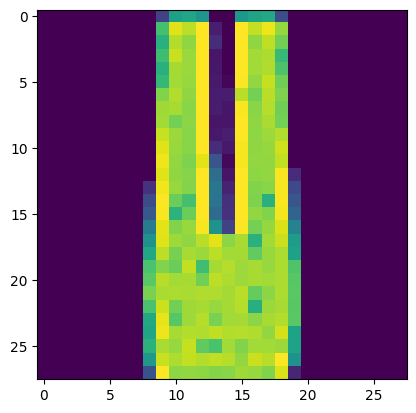

In [ ]:
# Take one batch and show the first image
idx_img = 1
train_imgs, train_labels = next(iter(train_loader))
plt.imshow(train_imgs[idx_img].squeeze())
print('Label: ', train_labels[idx_img])

# Extract the values of the layer
out = feature_extractor(train_imgs.to(device))

# Either print the dimension or the actual value
print('Size of layer 1: ', out['feature 1'].size())
print('Size of layer 2: ', out['feature 2'].size())
print('Size of layer 5: ', out['feature 5'].size())
print('Size of layer 14: ', out['feature 14'].size())


Remark: Review the last question of homework 3 to see the reason why the feature looks like below

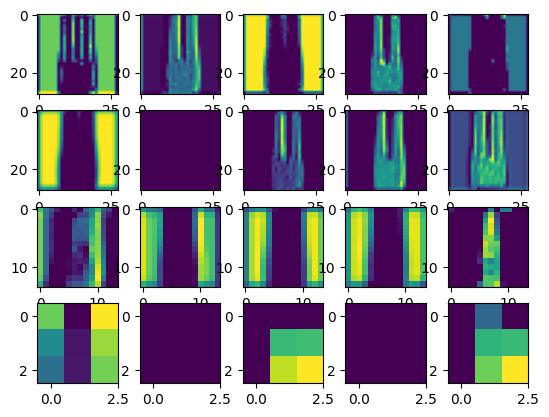

In [ ]:
# Visualize the first 5 channels of each hidden layer
layers = ['feature 1', 'feature 2', 'feature 5', 'feature 14']

fig, axarr = plt.subplots(4, 5)
for i in range(len(layers)):
  act = out[layers[i]][1]
  for idx in range(5):
    axarr[i, idx].imshow(act[idx].detach().cpu())
